In [19]:
import os
import sys
import subprocess
import numpy as np
import pandas as pd
import math

from itertools import chain, product
from random import choice
from multiprocessing import Pool

import matplotlib.pyplot as plt
from scipy.misc import imread, imresize

In [20]:
# Random Geometry
def generate_random_rays(im, sample_size=100):
    rays = []
    height, width = im.shape
    for _ in range(sample_size):
        start_horizontal = choice([True, False])    
        start_x = 0 if start_horizontal else choice(range(width))
        start_y = choice(range(height)) if start_horizontal else 0
        end_horizontal = choice([True, False])    
        end_x = width if end_horizontal else choice(range(width))
        end_y = choice(range(height)) if end_horizontal else height
        rays.append(((start_x, start_y), (end_x, end_y)))
    return rays

In [21]:
PARAMS_TO_FLAGS = {
    'input_file': '-i',
    'output_file': '-o',
    'rays': '-rays',
    'd_w': '-d_w',
    'd_h': '-d_h',
    'max_comp': '-max_comp'
}

def output_to_dict(output):
    # Parsear la salida a un diccionario
    lines = output.decode().split('\n')
    d = dict(tuple(l.split(': ')) for l in lines if ': ' in l)
    return d

def run(exc_path, params):
    args = tuple(chain(*((PARAMS_TO_FLAGS[p], str(v)) for p, v in params.items())))
    args = [exc_path, *args]
    output = subprocess.check_output(args)
    return output_to_dict(output)


def run_grid_in_parallel(run_func, grid, n_proc=2):
    """Run a grid on n_proc workers"""
    done, results = 0, []
    
    def call_back(out):
        nonlocal done
        nonlocal results
        results.append(out)
        done += 1
        print('\r', f'Point {done}/{len(grid)} done', end='         ')
        sys.stdout.flush()

    with Pool(n_proc) as pool:
        for point in grid:
            kw = point
            imfile = kw.pop('imfile')
            pool.apply_async(run_func, (imfile, ), kw, callback=call_back)
        pool.close()
        pool.join()
    return pd.DataFrame(results)

In [22]:
EXECUTABLE = '../codigo/build/tp3'
RAY_GENERATORS = {
    'random': generate_random_rays,
    #'horizontal': generate_rays_horizontal, 
    #'horizontal + vertical': generate_rays_hv
}

def rays_to_csv(outfname, rays_l):
    with open(outfname, 'w') as f:
        for ray in rays_l:
            f.write('{},{},{},{}\n'.format(ray[0][0], ray[0][1], 
                                         ray[1][0], ray[1][1]))

def reconstruction(imfile=None,
                   generator_params=None, 
                   disc_h=25, disc_w=25,
                   ray_generator='random', 
                   outdir='../recursosTP3/results/',
                   outname='reconstruction',
                   run_params=None,
                   **kwargs):
    im = imread(imfile, 'L')
    rows, cols = im.shape
    rays = RAY_GENERATORS[ray_generator](im, **generator_params)
    rays_to_csv(outdir + '/' + outname + '_rays.csv', rays)
    params = {
        'input_file': imfile,
        'output_file': outdir + '/' + outname + '.png',
        'rays': outdir + '/' + outname + '_rays.csv',
        'd_w': str(disc_w),
        'd_h': str(disc_h),
        
    }
    if run_params:
        params.update(run_params)
    res = run(EXECUTABLE, params)
    params['rays_generated'] = len(rays)
    params['generator'] = ray_generator
    params['generator_params'] = generator_params
    params['output'] = res
    return params

In [36]:
i_file = '../recursosTP3/data/tomo.png'
o_dir = '../recursosTP3/results'
o_name = 'tomoreconstructionGasti'
ray_generator='random'
ray_generator_params = {
    'sample_size' : 1000
}
res = reconstruction(i_file, ray_generator_params,
               ray_generator='random', 
               outdir=o_dir, outname=o_name)

/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


PSNR: 28.097301397780225
MSE: 100.7744


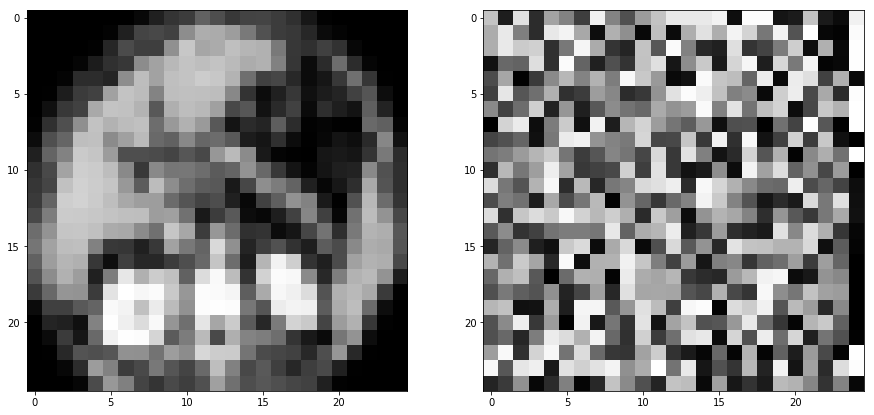

In [37]:
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def mse(img1, img2):
    return np.mean( (img1 - img2) ** 2 )


def compute_error(original_imfile, reconstruction_imfile):
    original_im = imread(original_imfile, 'L')
    r_im = imread(reconstruction_imfile)
    r_rows, r_cols = r_im.shape
    original_resized = imresize(original_im, (r_rows, r_cols))
    print(f"PSNR: {psnr(r_im, original_resized)}")
    print(f"MSE: {mse(r_im, original_resized)}")
    f, [ax1, ax2] = plt.subplots(1, 2, figsize=(15,15))
    ax1.imshow(original_resized, cmap='gray')
    ax2.imshow(r_im, cmap='gray')
    
compute_error(res['input_file'], res['output_file'])

In [41]:
from itertools import product
experiments  = {   
    f'h_resolution_at_{i}':{
            'imfile': '../recursosTP3/data/tomo.png',
            'outdir': '../recursosTP3/results',
            'outname': f'tomoreconstruction_{i}',
            'ray_generator': 'random',
            'generator_params': {
                'sample_size' : i
            }
        }
    for i in [100, 200, 500, 1000, 5000, 10000, 25000, 50000]
}

grid = experiments.values()
res = run_grid_in_parallel(reconstruction, grid)

/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


 Point 8/8 done         

In [42]:
res.head()

,d_h,d_w,generator,generator_params,input_file,output,output_file,rays,rays_generated
0,25,25,random,{'sample_size': 100},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/tomoreconstruction_100.png,../recursosTP3/results/tomoreconstruction_100_...,100
1,25,25,random,{'sample_size': 200},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/tomoreconstruction_200.png,../recursosTP3/results/tomoreconstruction_200_...,200
2,25,25,random,{'sample_size': 500},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/tomoreconstruction_500.png,../recursosTP3/results/tomoreconstruction_500_...,500
3,25,25,random,{'sample_size': 1000},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/tomoreconstruction_1000...,../recursosTP3/results/tomoreconstruction_1000...,1000
4,25,25,random,{'sample_size': 5000},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/tomoreconstruction_5000...,../recursosTP3/results/tomoreconstruction_5000...,5000


In [69]:
def psnr(u_0, u_1):
    rows, cols = u_0.shape
    N = rows * cols
    ecm = (1 / N)  * np.sum(np.power(u_1 - u_0, 2))
    return 10 * np.log(u_0.max() ** 2 / ecm)

def compute_error(original_imfile, reconstruction_imfile):
    original_im = imread(original_imfile, 'L')
    r_im = imread(reconstruction_imfile)
    r_rows, r_cols = r_im.shape
    original_resized = imresize(original_im, (r_rows, r_cols))
    error = psnr(r_im, original_resized)
    return error

def compute_error_mse(original_imfile, reconstruction_imfile):
    original_im = imread(original_imfile, 'L')
    r_im = imread(reconstruction_imfile)
    r_rows, r_cols = r_im.shape
    original_resized = imresize(original_im, (r_rows, r_cols))
    error = mse(r_im, original_resized)
    return error

In [70]:
res['error'] = res.apply(lambda x: compute_error(x['input_file'], x['output_file']), axis=1)
res['mse'] = res.apply(lambda x: compute_error_mse(x['input_file'], x['output_file']), axis=1)

/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead

In [71]:
res

,d_h,d_w,generator,generator_params,input_file,output,output_file,rays,rays_generated,error,mse
0,25,25,random,{'sample_size': 100},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/tomoreconstruction_100.png,../recursosTP3/results/tomoreconstruction_100_...,100,64.410173,103.7008
1,25,25,random,{'sample_size': 200},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/tomoreconstruction_200.png,../recursosTP3/results/tomoreconstruction_200_...,200,65.190960,95.9120
2,25,25,random,{'sample_size': 500},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/tomoreconstruction_500.png,../recursosTP3/results/tomoreconstruction_500_...,500,64.258884,105.2816
3,25,25,random,{'sample_size': 1000},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/tomoreconstruction_1000...,../recursosTP3/results/tomoreconstruction_1000...,1000,64.737474,100.3616
4,25,25,random,{'sample_size': 5000},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/tomoreconstruction_5000...,../recursosTP3/results/tomoreconstruction_5000...,5000,64.362457,104.1968
5,25,25,random,{'sample_size': 10000},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/tomoreconstruction_1000...,../recursosTP3/results/tomoreconstruction_1000...,10000,64.946414,98.2864
6,25,25,random,{'sample_size': 25000},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/tomoreconstruction_2500...,../recursosTP3/results/tomoreconstruction_2500...,25000,64.617041,101.5776
7,25,25,random,{'sample_size': 50000},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/tomoreconstruction_5000...,../recursosTP3/results/tomoreconstruction_5000...,50000,64.147502,106.4608


In [52]:
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def mse(img1, img2):
    return np.mean( (img1 - img2) ** 2 )


def compute_error(original_imfile, reconstruction_imfile):
    original_im = imread(original_imfile, 'L')
    r_im = imread(reconstruction_imfile)
    r_rows, r_cols = r_im.shape
    original_resized = imresize(original_im, (r_rows, r_cols))
    print(f"PSNR: {psnr(r_im, original_resized)}")
    print(f"MSE: {mse(r_im, original_resized)}")
    f, [ax1, ax2] = plt.subplots(1, 2, figsize=(15,15))
    ax1.imshow(original_resized, cmap='gray')
    ax2.imshow(r_im, cmap='gray')

/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


PSNR: 27.972982541004185
MSE: 103.7008
PSNR: 28.312074136790034
MSE: 95.912
PSNR: 27.907278844280935
MSE: 105.2816
PSNR: 28.115127844944475
MSE: 100.3616
PSNR: 27.952259793677648
MSE: 104.1968
PSNR: 28.205869326957238
MSE: 98.2864
PSNR: 28.062824134411898
MSE: 101.5776
PSNR: 27.85890635511729
MSE: 106.4608


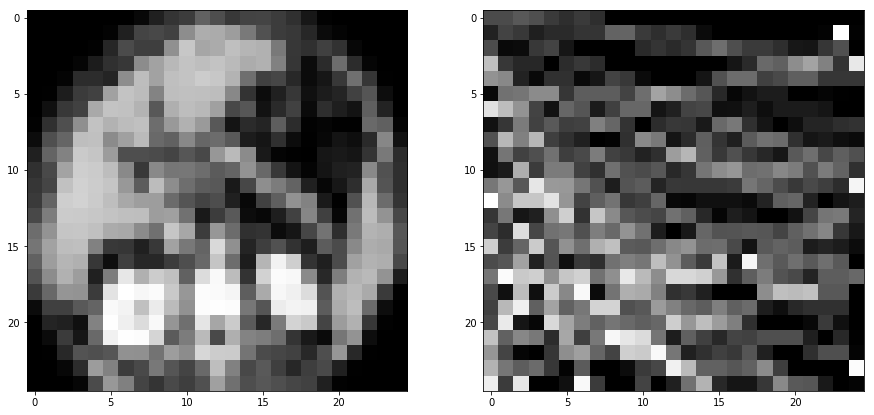

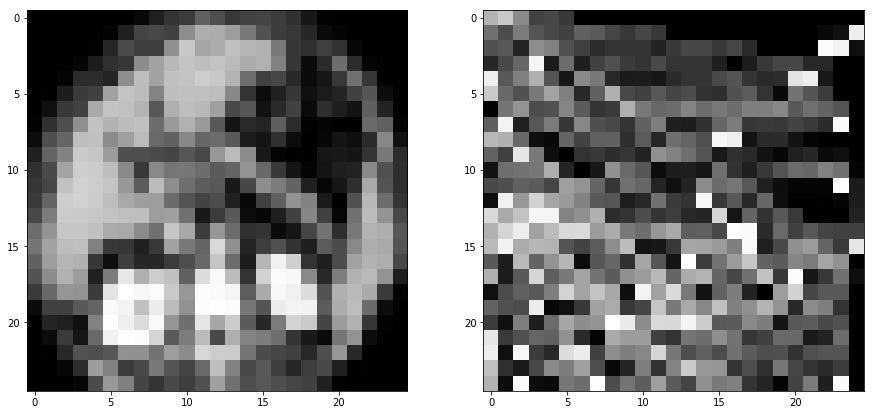

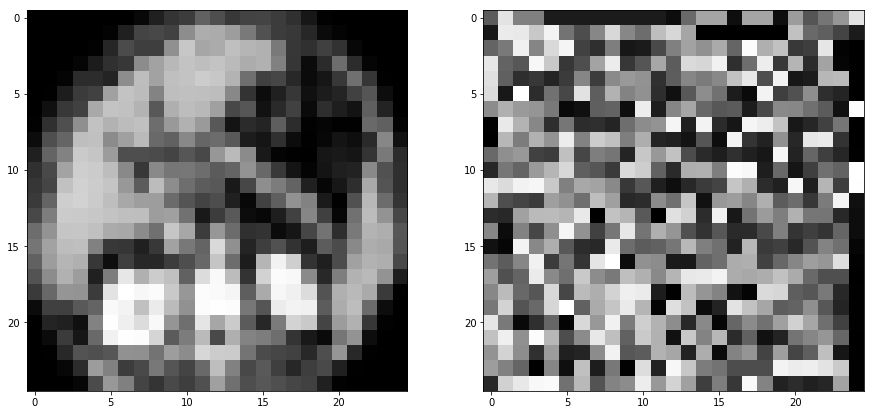

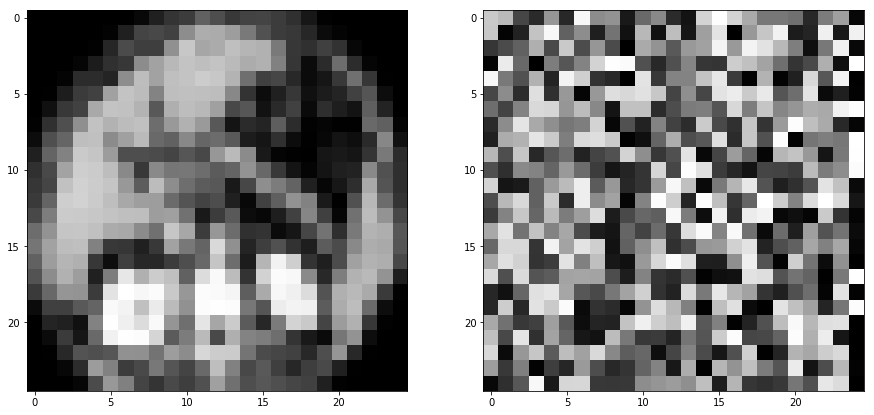

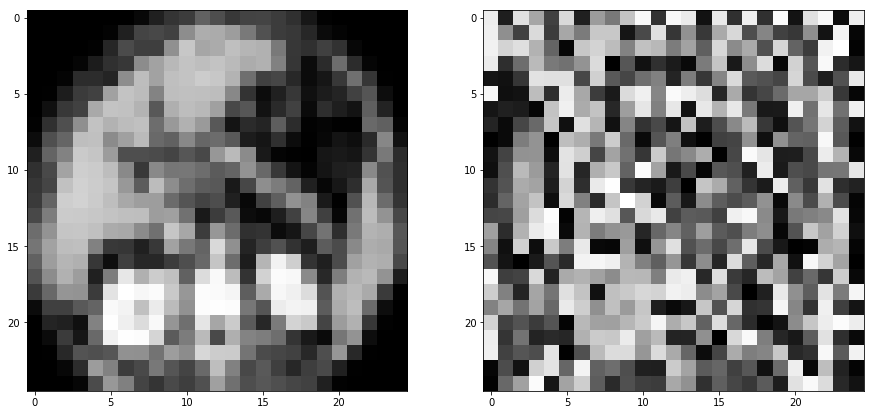

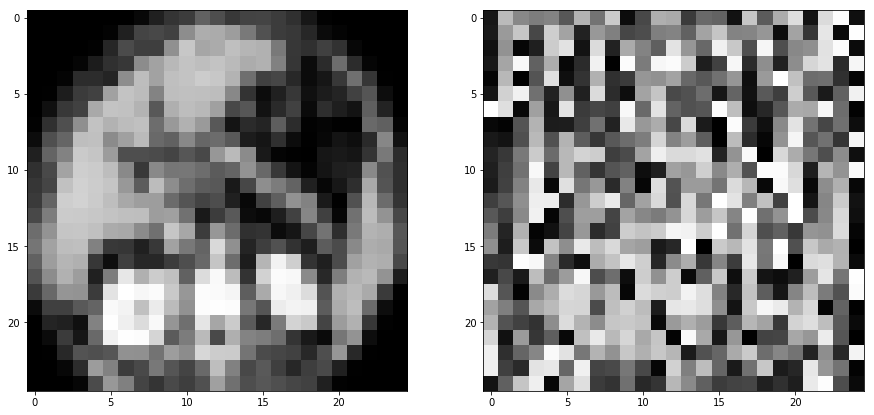

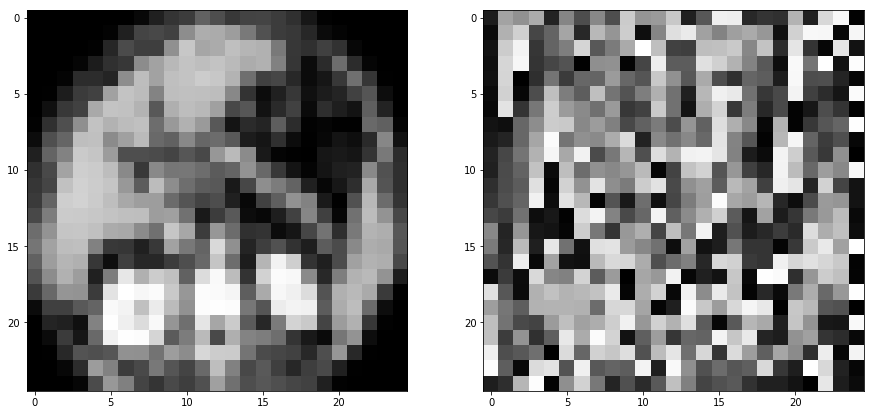

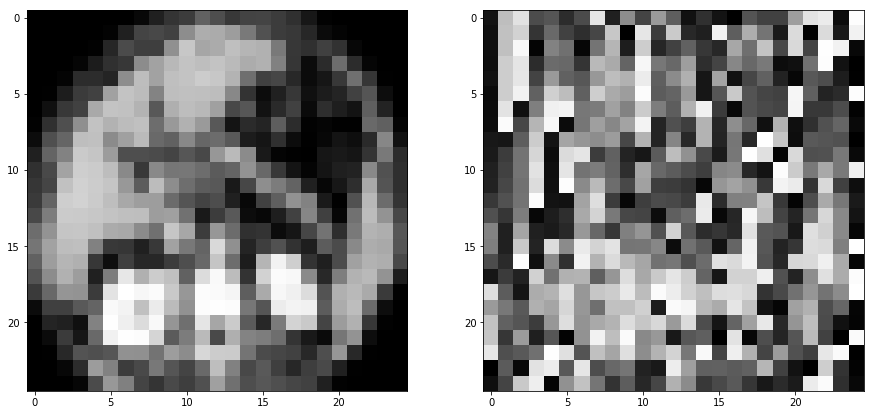

In [53]:
res['error'] = res.apply(lambda x: compute_error(x['input_file'], x['output_file']), axis=1)

## Error vs tamaño de la discretizacion

In [61]:
experiments  = {   
    f'discretization_{i}':{
            'imfile': '../recursosTP3/data/tomo.png',
            'outdir': '../recursosTP3/results/discretization',
            'outname': f'tomo_reconstruction_discretization_{i}',
            'ray_generator': 'random',
            'disc_h':i, 
            'disc_w':i,
            'generator_params': {
                'sample_size' : 10000,
            }
        }
    for i in [20, 25, 30, 40]
}

grid = experiments.values()
res_disc = run_grid_in_parallel(reconstruction, grid)

/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


 Point 4/4 done         

In [62]:
res_disc

,d_h,d_w,generator,generator_params,input_file,output,output_file,rays,rays_generated
0,20,20,random,{'sample_size': 10000},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/discretization/tomo_rec...,../recursosTP3/results/discretization/tomo_rec...,10000
1,25,25,random,{'sample_size': 10000},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/discretization/tomo_rec...,../recursosTP3/results/discretization/tomo_rec...,10000
2,30,30,random,{'sample_size': 10000},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/discretization/tomo_rec...,../recursosTP3/results/discretization/tomo_rec...,10000
3,40,40,random,{'sample_size': 10000},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/discretization/tomo_rec...,../recursosTP3/results/discretization/tomo_rec...,10000


In [72]:
def psnr(u_0, u_1):
    rows, cols = u_0.shape
    N = rows * cols
    ecm = (1 / N)  * np.sum(np.power(u_1 - u_0, 2))
    return 10 * np.log(u_0.max() ** 2 / ecm)

def compute_error(original_imfile, reconstruction_imfile):
    original_im = imread(original_imfile, 'L')
    r_im = imread(reconstruction_imfile)
    r_rows, r_cols = r_im.shape
    original_resized = imresize(original_im, (r_rows, r_cols))
    error = psnr(r_im, original_resized)
    return error


def compute_error_mse(original_imfile, reconstruction_imfile):
    original_im = imread(original_imfile, 'L')
    r_im = imread(reconstruction_imfile)
    r_rows, r_cols = r_im.shape
    original_resized = imresize(original_im, (r_rows, r_cols))
    error = mse(r_im, original_resized)
    return error

In [73]:
res_disc['error'] = res.apply(lambda x: compute_error(x['input_file'], x['output_file']), axis=1)
res_disc['mse'] = res.apply(lambda x: compute_error_mse(x['input_file'], x['output_file']), axis=1)

/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead

In [74]:
res_disc

,d_h,d_w,generator,generator_params,input_file,output,output_file,rays,rays_generated,error,mse
0,20,20,random,{'sample_size': 10000},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/discretization/tomo_rec...,../recursosTP3/results/discretization/tomo_rec...,10000,64.410173,103.7008
1,25,25,random,{'sample_size': 10000},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/discretization/tomo_rec...,../recursosTP3/results/discretization/tomo_rec...,10000,65.190960,95.9120
2,30,30,random,{'sample_size': 10000},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/discretization/tomo_rec...,../recursosTP3/results/discretization/tomo_rec...,10000,64.258884,105.2816
3,40,40,random,{'sample_size': 10000},../recursosTP3/data/tomo.png,"{'Input File': '../recursosTP3/data/tomo.png',...",../recursosTP3/results/discretization/tomo_rec...,../recursosTP3/results/discretization/tomo_rec...,10000,64.737474,100.3616


/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``image

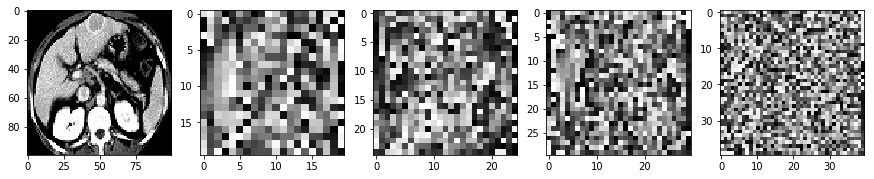

In [64]:
f, axarr = plt.subplots(1, 5, figsize=(15,15))
axarr[0].imshow(imread(res_disc.iloc[0]['input_file']), cmap='gray')
axarr[1].imshow(imread(res_disc.iloc[0]['output_file']), cmap='gray')
axarr[2].imshow(imread(res_disc.iloc[1]['output_file']), cmap='gray')
axarr[3].imshow(imread(res_disc.iloc[2]['output_file']), cmap='gray')
axarr[4].imshow(imread(res_disc.iloc[3]['output_file']), cmap='gray')

## Valores singulares y error

In [75]:
i_file = '../recursosTP3/data/tomo.png'
o_dir = '../recursosTP3/results'
o_name = 'tomoreconstruction1'
ray_generator='random'
ray_generator_params = {
    'sample_size' : 10000,
}
res_sing = reconstruction(i_file, ray_generator_params, 
                     d_h=25, d_w=25,
                     ray_generator='random', 
                     outdir=o_dir, outname=o_name)

/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [76]:
res_sing

{'input_file': '../recursosTP3/data/tomo.png',
 'output_file': '../recursosTP3/results/tomoreconstruction1.png',
 'rays': '../recursosTP3/results/tomoreconstruction1_rays.csv',
 'd_w': '25',
 'd_h': '25',
 'rays_generated': 10000,
 'generator': 'random',
 'generator_params': {'sample_size': 10000},
 'output': {'Input File': '../recursosTP3/data/tomo.png',
  'Output File': '../recursosTP3/results/tomoreconstruction1.png',
  'Discretization Size': '25x25',
  'Eigenvalue 0 ': '147972',
  'Eigenvalue 1 ': '82916.7',
  'Eigenvalue 2 ': '65585.9',
  'Eigenvalue 3 ': '53135.5',
  'Eigenvalue 4 ': '47124.9',
  'Eigenvalue 5 ': '44216.6',
  'Eigenvalue 6 ': '40906',
  'Eigenvalue 7 ': '39397.1',
  'Eigenvalue 8 ': '37756',
  'Eigenvalue 9 ': '34404.2',
  'Eigenvalue 10 ': '31677.3',
  'Eigenvalue 11 ': '30535.9',
  'Eigenvalue 12 ': '29612.6',
  'Eigenvalue 13 ': '27369',
  'Eigenvalue 14 ': '26395.3',
  'Eigenvalue 15 ': '25924.4',
  'Eigenvalue 16 ': '24720.8',
  'Eigenvalue 17 ': '23992.9',


In [104]:
from math import sqrt
def singular_values(res_dict):
    svalues = filter(lambda x: 'Eigenvalue' in x, res_dict['output'])
    return {int(k.split(' ')[1]): sqrt(float(v)) for k, v in res_dict['output'].items() if 'Eigenvalue' in k}

sv = singular_values(res_sing)

Text(0,0.5,'Numero de Condicion')

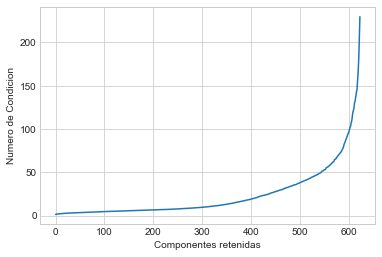

In [105]:
s = sorted(sv.values(), reverse=True)
condition_number = [(s[0] / s2) for s2 in s[1:]]

plt.plot(condition_number)
plt.xlabel('Componentes retenidas')
plt.ylabel('Numero de Condicion')

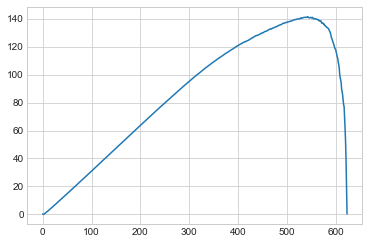

In [106]:
l = np.array([1, condition_number[0]])
h = np.array([len(condition_number), condition_number[-1]])

def distance_to_opt(l, h, p):
    d = np.linalg.norm(np.cross(l-h, l-p))/np.linalg.norm(l-h)
    return d

dist = [distance_to_opt(l, h, np.array(p)) for p in enumerate(condition_number)]
plt.plot(dist)

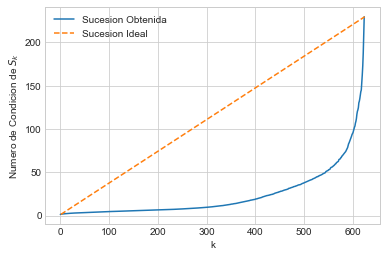

In [107]:
import seaborn as sns
sns.set_style('whitegrid')
s = sorted(sv.values(), reverse=True)
condition_number = [(s[0] / s2) for s2 in s[1:]]

l = np.array([1, condition_number[0]])
h = np.array([len(condition_number), condition_number[-1]])

plt.plot(condition_number, label='Sucesion Obtenida')
plt.plot([l[0], h[0]], [l[1], h[1]], linestyle='--' , label='Sucesion Ideal')

plt.xlabel('k')
plt.ylabel(r'Numero de Condicion de $S_k$')
plt.legend()
l = np.array([1, condition_number[0]])
h = np.array([len(condition_number), condition_number[-1]])



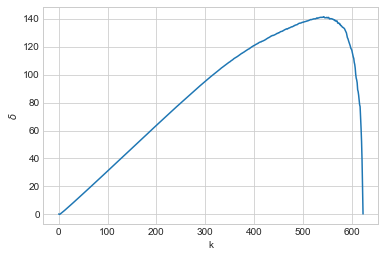

In [108]:
def distance_to_opt(l, h, p):
    d = np.linalg.norm(np.cross(l-h, l-p))/np.linalg.norm(l-h)
    return d

dist = [distance_to_opt(l, h, np.array(p)) for p in enumerate(condition_number)]

plt.xlabel('k')
plt.ylabel(r'$\delta$')
plt.plot(dist)

In [80]:
np.argmax(dist)

543

In [81]:
i_file = '../recursosTP3/data/tomo.png'
o_dir = '../recursosTP3/results/condition_number'
o_name = 'tomoreconstruction_w_opt'
ray_generator='random'
ray_generator_params = {
    'sample_size' : 10000,
}
run_params = {
    'max_comp': 557,
}
res_w_filter = reconstruction(i_file, 
                              ray_generator_params, 
                              d_h=25, d_w=25,
                              ray_generator='random', 
                              outdir=o_dir,
                              outname=o_name,
                              run_params=run_params)

/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


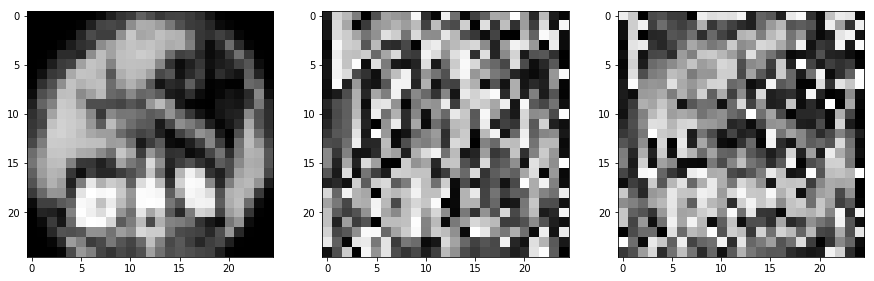

In [82]:
original_im = imread(res_sing['input_file'], 'L')
original_resized = imresize(original_im, (25, 25))
#original_resized = imresize(original_im, (25, 25))

f, axarr = plt.subplots(1, 3, figsize=(15,15))
axarr[0].imshow(original_resized, cmap='gray')
axarr[1].imshow(imread(res_sing['output_file']), cmap='gray')
axarr[2].imshow(imread(res_w_filter['output_file']), cmap='gray')

13.981672095726514
13.986960372342221
103.9312
103.6784


/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Text(0,0.5,'MSE')

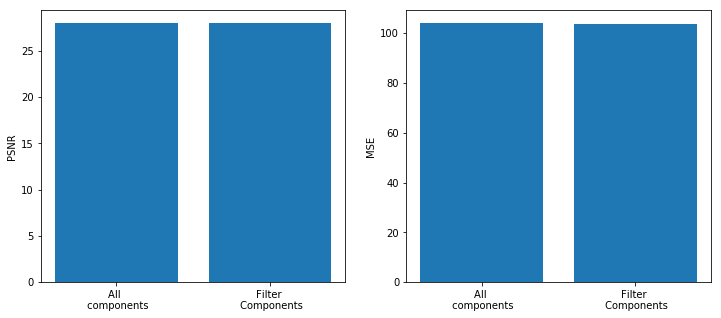

In [96]:
import math

#def psnr(u_0, u_1):
#    rows, cols = u_0.shape
#    N = rows * cols
#    ecm = (1 / N)  * np.sum(np.power(u_1 - u_0, 2))
#    return 10 * np.log(u_0.max() ** 2 / ecm)

def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    print(10 * math.log10(PIXEL_MAX / math.sqrt(mse)))
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def mse(img1, img2):
    print(np.mean( (img1 - img2) ** 2 ))
    return np.mean( (img1 - img2) ** 2 )

im_reconstruction = imread(res_sing['output_file'])
im_reconstruction_w_filter = imread(res_w_filter['output_file'])

im_reconstruction = imread(res_sing['output_file'])
im_reconstruction_w_filter = imread(res_w_filter['output_file'])
psnr_reconstruction = psnr(original_resized, im_reconstruction)
psnr_reconstruction_w_filter = psnr(original_resized, im_reconstruction_w_filter)

mse_reconstruction = mse(original_resized, im_reconstruction)
mse_reconstruction_w_filter = mse(original_resized, im_reconstruction_w_filter)


f, axarr = plt.subplots(1, 2, figsize=(12, 5) )
axarr[0].bar(['All \n components', 'Filter \n Components'], 
                [psnr_reconstruction, psnr_reconstruction_w_filter])
axarr[0].set_ylabel('PSNR')
axarr[1].bar(['All \n components', 'Filter \n Components'], 
                [mse_reconstruction, mse_reconstruction_w_filter])
axarr[1].set_ylabel('MSE')

## Other Images

/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


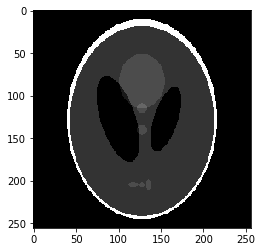

In [84]:
phantom = imread('../recursosTP3/data/phantom.png')
plt.imshow(phantom, cmap='gray')

In [86]:
i_file = '../recursosTP3/data/phantom.png'
o_dir = '../recursosTP3/results/phantom_random/'
o_name = 'phantom_reconstruction'
ray_generator='random'
ray_generator_params = {
    'sample_size' : 10000,
}
res_phantom = reconstruction(i_file, ray_generator_params, 
                             d_h=25, d_w=25,
                             ray_generator='random', 
                             outdir=o_dir, outname=o_name)

/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


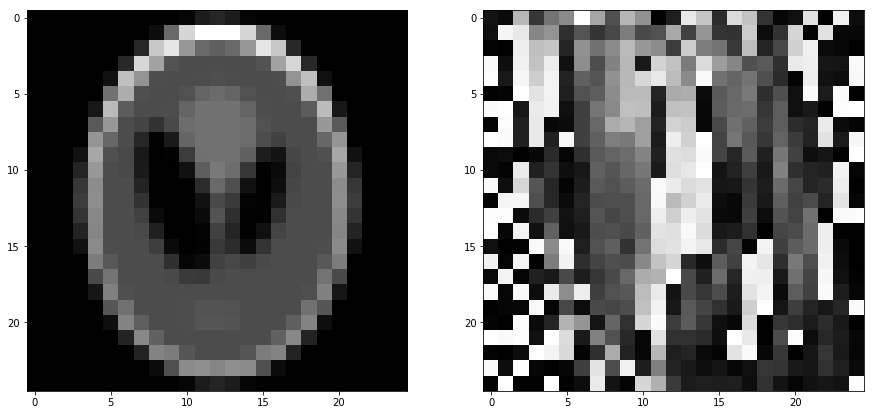

In [87]:
original_im = imread(res_phantom['input_file'], 'L')
original_resized = imresize(original_im, (25, 25))

f, axarr = plt.subplots(1, 2, figsize=(15,15))
axarr[0].imshow(original_resized, cmap='gray')
axarr[1].imshow(imread(res_phantom['output_file']), cmap='gray')

/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


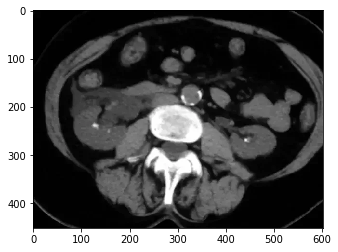

In [97]:
tomo2 = imread('../recursosTP3/data/tomo3.png')
plt.imshow(tomo2, cmap='gray')

In [98]:
np.array(tomo2.shape) / 24

array([18.83333333, 25.08333333,  0.16666667])

In [99]:
i_file = '../recursosTP3/data/tomo2.png'
o_dir = '../recursosTP3/results/tomo2_horizontal/'
o_name = 'phantom_reconstruction'
ray_generator='random'
ray_generator_params = {
    'sample_size' : 10000,
}
res_tomo2 = reconstruction(i_file, ray_generator_params, 
                             d_h=21, d_w=28,
                             ray_generator='random', 
                             outdir=o_dir, outname=o_name)

/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
/Users/Angseton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


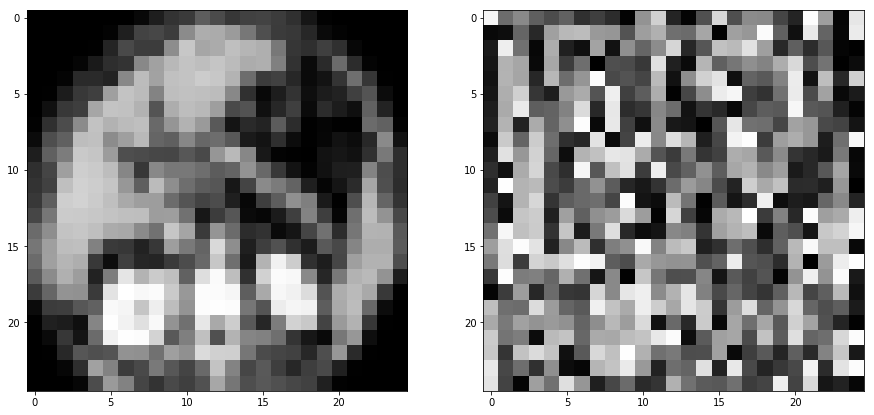

In [100]:
original_im = imread(res_tomo2['input_file'], 'L')
original_resized = imresize(original_im, (25, 25))

f, axarr = plt.subplots(1, 2, figsize=(15,15))
axarr[0].imshow(original_resized, cmap='gray')
axarr[1].imshow(imread(res_tomo2['output_file']), cmap='gray')